# Preprocessing for complex PDF

## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = "../../.."
add_python_path(module_path)

python path: /home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr is added
sys.path:  ['/home/ec2-user/anaconda3/envs/python3/lib/python310.zip', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10/lib-dynload', '', '/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages', '/home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr']


## 1. Create Bedrock client

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [5]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-Embeddings-V2': 'amazon.titan-embed-text-v2:0',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Expres

## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [6]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [7]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 2048,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f41dbb5e890>], client=<botocore.client.BedrockRuntime object at 0x7f41db5a5f60>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 2048, 'stop_sequences': ['\n\nHuman']}, streaming=True)

### Embedding 모델 선택

In [8]:
from langchain.embeddings import BedrockEmbeddings

In [9]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536 #1024
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. 데이터 준비 
- https://python.langchain.com/docs/integrations/document_loaders/unstructured_file
- cleansing: https://unstructured-io.github.io/unstructured/core/cleaning.html

### Extract Text, Table and Image from documents

### 3.1 Unstructured.io

In [10]:
import shutil
from glob import glob
from utils.common_utils import to_pickle, load_pickle
from unstructured.cleaners.core import clean_bullets, clean_extra_whitespace
from langchain_community.document_loaders import UnstructuredFileLoader, UnstructuredAPIFileLoader

#### Parameters
----------
- filename
    - A string defining the target filename path.
- content_type
    - A string defining the file content in MIME type
- file
    - A file-like object using "rb" mode --> open(filename, "rb").
- metadata_filename
    - When file is not None, the filename (string) to store in element metadata. E.g. "foo.txt"
- url
    - The url for a remote document. Pass in content_type if you want partition to treat the document as a specific content_type.
- include_page_breaks
    - If True, the output will include page breaks if the filetype supports it
- strategy
    - The strategy to use for partitioning PDF/image. Uses a layout detection model if set to 'hi_res', otherwise partition simply extracts the text from the document and processes it.
- encoding
    - The encoding method used to decode the text input. If None, utf-8 will be used.
- headers
    - The headers to be used in conjunction with the HTTP request if URL is set.
- skip_infer_table_types
    - The document types that you want to skip table extraction with.
- ssl_verify
    - If the URL parameter is set, determines whether or not partition uses SSL verification in the HTTP request.
- languages
    - The languages present in the document, for use in partitioning and/or OCR. For partitioning <BR>
    image or pdf documents with Tesseract, you'll first need to install the appropriate <BR>
    Tesseract language pack. For other partitions, language is detected using naive Bayesian <BR>
    filter via `langdetect`. Multiple languages indicates text could be in either language. <BR>
    Additional Parameters: <BR>
        - detect_language_per_element <BR>
            - Detect language per element instead of at the document level.
    
- pdf_infer_table_structure
    - If True and strategy=hi_res, any Table Elements extracted from a PDF will include an
    additional metadata field, "text_as_html," where the value (string) is a just a
    transformation of the data into an HTML <table>.
    The "text" field for a partitioned Table Element is always present, whether True or False.
- extract_images_in_pdf
    - Only applicable if `strategy=hi_res`.
    If True, any detected images will be saved in the path specified by
    'extract_image_block_output_dir' or stored as base64 encoded data within metadata fields.
    Deprecation Note: This parameter is marked for deprecation. Future versions will use
    'extract_image_block_types' for broader extraction capabilities.
- extract_image_block_types
    - Only applicable if `strategy=hi_res`.
    Images of the element type(s) specified in this list (e.g., ["Image", "Table"]) will be
    saved in the path specified by 'extract_image_block_output_dir' or stored as base64
    encoded data within metadata fields.
- extract_image_block_to_payload
    - Only applicable if `strategy=hi_res`.
    If True, images of the element type(s) defined in 'extract_image_block_types' will be
    encoded as base64 data and stored in two metadata fields: 'image_base64' and
    'image_mime_type'.
    This parameter facilitates the inclusion of element data directly within the payload,
    especially for web-based applications or APIs.
- extract_image_block_output_dir
    - Only applicable if `strategy=hi_res` and `extract_image_block_to_payload=False`.
    The filesystem path for saving images of the element type(s)
    specified in 'extract_image_block_types'.
- xml_keep_tags
    - If True, will retain the XML tags in the output. Otherwise it will simply extract
    the text from within the tags. Only applies to partition_xml.
- request_timeout
    - The timeout for the HTTP request if URL is set. Defaults to None meaning no timeout and
    requests will block indefinitely.
- hi_res_model_name
    - The layout detection model used when partitioning strategy is set to `hi_res`.
    - https://unstructured-io.github.io/unstructured/best_practices/models.html
- model_name
    - The layout detection model used when partitioning strategy is set to `hi_res`. To be
    deprecated in favor of `hi_res_model_name`.

In [11]:
image_path = "./fig"

#file_path = "./data/complex_pdf/sales-portal.pdf"
#file_path = "./data/complex_pdf/school_edu_guide.pdf"
#file_path="./data/complex_pdf/l-test.pdf"
#file_path="./data/complex_pdf/safety-administrator-job-manual.pdf"
file_path = "./data/complex_pdf/llm_usage_report.pdf"

In [12]:
if os.path.isdir(image_path): shutil.rmtree(image_path)
os.mkdir(image_path)

loader = UnstructuredFileLoader(
    file_path=file_path,

    chunking_strategy = "by_title",
    mode="elements",

    strategy="hi_res",
    hi_res_model_name="yolox", #"detectron2_onnx", "yolox", "yolox_quantized"

    extract_images_in_pdf=True,
    #skip_infer_table_types='[]', # ['pdf', 'jpg', 'png', 'xls', 'xlsx', 'heic']
    pdf_infer_table_structure=True, ## enable to get table as html using tabletrasformer

    extract_image_block_output_dir=image_path,
    extract_image_block_to_payload=False, ## False: to save image

    max_characters=4096,
    new_after_n_chars=4000,
    combine_text_under_n_chars=2000,

    languages= ["kor+eng"],

    post_processors=[clean_bullets, clean_extra_whitespace]
)

In [13]:
%%time
docs = loader.load()

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 48.1 s, sys: 1.99 s, total: 50.1 s
Wall time: 1min 9s


#### Save parsing data

In [14]:
to_pickle(docs, "./data/complex_pdf/pickle/parsed_unstructured.pkl")
docs = load_pickle("./data/complex_pdf/pickle/parsed_unstructured.pkl")

To_PICKLE: ./data/complex_pdf/pickle/parsed_unstructured.pkl
Load from ./data/complex_pdf/pickle/parsed_unstructured.pkl


In [15]:
# from distutils.dir_util import copy_tree
# from_file_path = './fig' # 복사할 폴더
# to_file_path = './fig-origin' # 복사 위치
# copy_tree(from_file_path, to_file_path)

In [16]:
# os.rmdir(from_file_path)
# from_file_path = './fig-origin'
# to_file_path = './fig'
# copy_tree(from_file_path, to_file_path)

In [17]:
# pdf2image

# import fitz
# doc = fitz.open(file_path)
# for i, page in enumerate(doc):
#     img = page.get_pixmap()
#     img.save(f'{image_path}/figure-{i}.png')


In [18]:
tables, texts = [], []
images = glob(os.path.join(image_path, "*"))

In [19]:
tables, texts = [], []

for doc in docs:

    category = doc.metadata["category"]

    if category == "Table": tables.append(doc)
    elif category == "Image": images.append(doc)
    else: texts.append(doc)
    
    images = glob(os.path.join(image_path, "*"))

print (f' # texts: {len(texts)} \n # tables: {len(tables)} \n # images: {len(images)}')

 # texts: 5 
 # tables: 4 
 # images: 26


### 3.1 (Optional) table parsing using Llama-parse

In [20]:
import nest_asyncio
from dotenv import load_dotenv
from llama_parse import LlamaParse
from utils.common_utils import to_markdown
from langchain_community.document_loaders import UnstructuredMarkdownLoader

In [21]:
table_by_llama_parse = False

In [22]:
def api_key():
    os.environ["LLAMA_CLOUD_API_KEY"] = "<your key>"
    nest_asyncio.apply()
    load_dotenv()

In [23]:
if table_by_llama_parse:
    api_key()
    llamaparse_res = LlamaParse(result_type="markdown").load_data(file_path)
    
    ## Save results as markdown and pickle format
    markdown_path = "./data/complex_pdf/pickle/parsed_llamaparse.md"
    to_pickle(llamaparse_res, "./data/complex_pdf/pickle/parsed_llamaparse.pkl")
    to_markdown(llamaparse_res[0].get_content('text'), markdown_path)
    
    ## Load markdown file into Document loader
    loader = UnstructuredMarkdownLoader(
        file_path=markdown_path,
        mode="elements",
        chunking_strategy="by_title",
        #strategy="hi_res",
        max_characters=4096,
        new_after_n_chars=4000,
        combine_text_under_n_chars=2000,
    )
    docs_llamaparse = loader.load()
    docs_table_llamaparse = [doc for doc in docs_llamaparse if doc.metadata["category"] == "Table"]

#### Show as markdown

In [24]:
from IPython.display import Markdown, display

In [25]:
if table_by_llama_parse:
    display(Markdown(markdown_path))

### 3.2 (Optional) table parsing using pyMuPDF

In [26]:
import fitz
from utils.pymupdf import to_markdown_pymupdf

In [27]:
table_by_pymupdf = False

In [28]:
if table_by_pymupdf:
    pymupdf_res = fitz.open(file_path)
    md_text = to_markdown_pymupdf(pymupdf_res) # get markdown string for all pages
    markdown_path = "./data/complex_pdf/pickle/parsed_pymupdf.md"
    to_markdown(md_text, markdown_path)

    ## Load markdown file into Document loader
    loader = UnstructuredMarkdownLoader(
        file_path=markdown_path,
        mode="elements",
        chunking_strategy="by_title",
        #strategy="hi_res",
        max_characters=4096,
        new_after_n_chars=4000,
        combine_text_under_n_chars=2000,
    )
    docs_pymupdf = loader.load()
    docs_table_pymupdf = [doc for doc in docs_pymupdf if doc.metadata["category"] == "Table"]

In [29]:
if table_by_pymupdf:
    display(Markdown(markdown_path))

### 3.3 (Optional) table as image

In [30]:
import cv2
import math
import base64
import numpy as np
from pdf2image import convert_from_path

In [31]:
def image_to_base64(image_path):
    
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
        
    return encoded_string.decode('utf-8')

In [32]:
table_as_image = True

### Extract and resize (sclae down) images 
- [reference](https://daewoonginfo.blogspot.com/2019/05/opencv-python-resize.html)
- [image token]: Claude 3 uses this formula tokens = (width px * height px)/750  to calculate # of input tokens associated with Images (for their Visual capabilities). Images bigger than ~1600 tokens would be scaled down

In [33]:
if table_as_image:
    image_tmp_path = os.path.join(image_path, "tmp")
    if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
    os.mkdir(image_tmp_path)
    
    # from pdf to image
    pages = convert_from_path(file_path)
    for i, page in enumerate(pages):
        print (f'pdf page {i}, size: {page.size}')    
        page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")

    print ("==")

    #table_images = []
    for idx, table in enumerate(tables):
        points = table.metadata["coordinates"]["points"]
        page_number = table.metadata["page_number"]
        layout_width, layout_height = table.metadata["coordinates"]["layout_width"], table.metadata["coordinates"]["layout_height"]

        img = cv2.imread(f'{image_tmp_path}/{page_number}.jpg')
        crop_img = img[math.ceil(points[0][1]):math.ceil(points[1][1]), \
                       math.ceil(points[0][0]):math.ceil(points[3][0])]
        table_image_path = f'{image_path}/table-{idx}.jpg'
        cv2.imwrite(table_image_path, crop_img)
        #table_images.append(table_image_path)

        print (f'unstructured width: {layout_width}, height: {layout_height}')
        print (f'page_number: {page_number}')
        print ("==")

        width, height, _ = crop_img.shape
        image_token = width*height/750
        print (f'image: {table_image_path}, shape: {img.shape}, image_token_for_claude3: {image_token}' )

        ## Resize image
        if image_token > 1500:
            resize_img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
            print("   - resize_img.shape = {0}".format(resize_img.shape))
            table_image_resize_path = table_image_path.replace(".jpg", "-resize.jpg")
            cv2.imwrite(table_image_resize_path, resize_img)
            os.remove(table_image_path)
            table_image_path = table_image_resize_path

        img_base64 = image_to_base64(table_image_path)
        table.metadata["image_base64"] = img_base64

    if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
    #print (f'table_images: {table_images}')
    images = glob(os.path.join(image_path, "*"))
    print (f'images: {images}')

pdf page 0, size: (1653, 2337)
pdf page 1, size: (1653, 2337)
pdf page 2, size: (1653, 2337)
pdf page 3, size: (1653, 2337)
pdf page 4, size: (1653, 2337)
pdf page 5, size: (1653, 2337)
pdf page 6, size: (1653, 2337)
==
unstructured width: 1653, height: 2337
page_number: 3
==
image: ./fig/table-0.jpg, shape: (2337, 1653, 3), image_token_for_claude3: 303.12
unstructured width: 1653, height: 2337
page_number: 4
==
image: ./fig/table-1.jpg, shape: (2337, 1653, 3), image_token_for_claude3: 631.904
unstructured width: 1653, height: 2337
page_number: 5
==
image: ./fig/table-2.jpg, shape: (2337, 1653, 3), image_token_for_claude3: 1062.604
unstructured width: 1653, height: 2337
page_number: 6
==
image: ./fig/table-3.jpg, shape: (2337, 1653, 3), image_token_for_claude3: 447.5466666666667
images: ['./fig/figure-1-6.jpg', './fig/figure-7-25.jpg', './fig/table-3.jpg', './fig/figure-1-8.jpg', './fig/figure-4-15.jpg', './fig/figure-7-22.jpg', './fig/figure-1-3.jpg', './fig/figure-1-1.jpg', './fig/fi

In [34]:
# # !pip install "camelot-py[base]"
# # !pip install PyPDF2~=2.0
# import camelot
# tables_camleot = camelot.read_pdf("./data/complex_pdf/sample.pdf")
# tables_camleot[0].df.to_html()
# tables_camleot[0].df.to_markdown()

### Summarization of table and image
- BedrockChat with claude3: https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8

In [35]:
from langchain.schema import Document
from langchain_core.messages import HumanMessage
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

In [36]:
system_prompt = "You are an assistant tasked with describing table and image."
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

### For images

In [37]:
import time
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import botocore
from utils.common_utils import retry

In [38]:
human_prompt = [
    {
        "type": "image_url",
        "image_url": {
            "url": "data:image/png;base64," + "{image_base64}",
        },
    },
    {
        "type": "text",
        "text": '''
                 Given image, give a concise summary.
                 Don't insert any XML tag such as <text> and </text> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [39]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

summarize_chain = prompt | llm_text | StrOutputParser()
#summarize_chain = {"image_base64": lambda x:x} | prompt | llm_text | StrOutputParser()

In [40]:
img_info = [image_to_base64(img_path) for img_path in images if os.path.basename(img_path).startswith("figure")]

In [41]:
@retry(total_try_cnt=5, sleep_in_sec=10, retryable_exceptions=(botocore.exceptions.EventStreamError))
def summary_img(summarize_chain, img_base64):

    img = Image.open(BytesIO(base64.b64decode(img_base64)))
    plt.imshow(img)
    plt.show()

    summary = summarize_chain.invoke(
        {
            "image_base64": img_base64
        }
    )

    return summary

INFO:retry-bedrock-invocation:trying summary_img() [1/5]


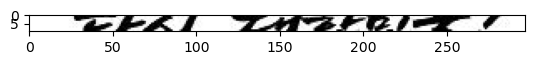

주어진 이미지는 전체적으로 검은색 바탕에 "TLTL tztzfzlzz /"라는 흰색 텍스트가 여러 줄로 반복되어 있는 모습입니다. 이미지의 내용이나 의미는 알기 어렵지만 추상적이고 미니멀한 디자인을 보여주고 있습니다. 텍스트의 반복적인 패턴과 단순한 색상 대비로 인해 모던하고 실험적인 예술 작품 같은 인상을 줍니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 전체적으로 검은색 바탕에 "TLTL tztzfzlzz /"라는 흰색 텍스트가 여러 줄로 반복되어 있는 모습입니다. 이미지의 내용이나 의미는 알기 어렵지만 추상적이고 미니멀한 디자인을 보여주고 있습니다. 텍스트의 반복적인 패턴과 단순한 색상 대비로 인해 모던하고 실험적인 예술 작품 같은 인상을 줍니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
0


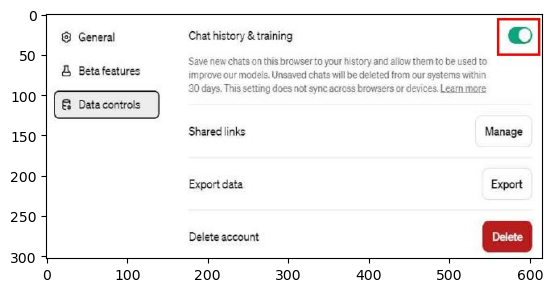

주어진 이미지는 AI 채팅 모델의 설정 메뉴를 보여주고 있습니다. 일반, 베타 기능, 데이터 제어 등의 옵션이 있으며, 채팅 내역과 모델 학습 데이터를 저장하거나 공유 링크를 관리할 수 있습니다. 또한 사용자 데이터를 내보내거나 계정을 삭제할 수 있는 옵션도 제공됩니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 AI 채팅 모델의 설정 메뉴를 보여주고 있습니다. 일반, 베타 기능, 데이터 제어 등의 옵션이 있으며, 채팅 내역과 모델 학습 데이터를 저장하거나 공유 링크를 관리할 수 있습니다. 또한 사용자 데이터를 내보내거나 계정을 삭제할 수 있는 옵션도 제공됩니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
1


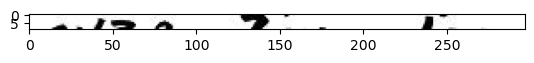

주어진 이미지는 한국의 전통 창호문양을 담고 있는 디자인 요소의 모음입니다. 상단에는 반달 모양의 긴 원형 문양과 구름 모양의 장식이 있고, 하단에는 물결 모양의 기하학적 문양과 식물 모티프 등 다양한 전통 문양 요소들이 있습니다. 이러한 한국 전통 미술 양식의 디자인 요소들이 현대적으로 재해석되어 있는 이미지입니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 한국의 전통 창호문양을 담고 있는 디자인 요소의 모음입니다. 상단에는 반달 모양의 긴 원형 문양과 구름 모양의 장식이 있고, 하단에는 물결 모양의 기하학적 문양과 식물 모티프 등 다양한 전통 문양 요소들이 있습니다. 이러한 한국 전통 미술 양식의 디자인 요소들이 현대적으로 재해석되어 있는 이미지입니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
2


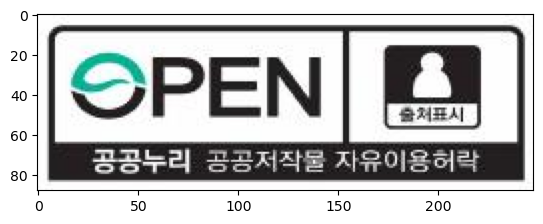

주어진 이미지는 한국어와 영어로 "Open"이라는 단어와 함께 상점 영업 시간을 알리는 표지판을 보여주고 있습니다. 녹색과 흰색으로 디자인된 이 표지판은 상점이 현재 영업 중임을 간단명료하게 전달하고 있습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 한국어와 영어로 "Open"이라는 단어와 함께 상점 영업 시간을 알리는 표지판을 보여주고 있습니다. 녹색과 흰색으로 디자인된 이 표지판은 상점이 현재 영업 중임을 간단명료하게 전달하고 있습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
3


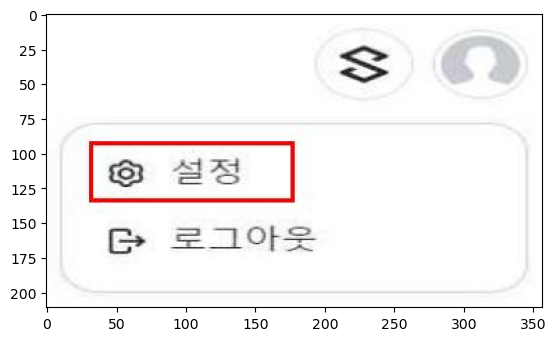

이미지는 한국어 설정 메뉴의 일부를 보여주고 있습니다. 설정 아이콘과 "설정" 텍스트가 빨간 상자로 강조되어 있습니다. 이는 사용자가 현재 설정 메뉴에 있음을 나타내는 것으로 보입니다. 또한 모그아웃 옵션도 표시되어 있어 사용자가 로그아웃할 수 있음을 보여줍니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '이미지는 한국어 설정 메뉴의 일부를 보여주고 있습니다. 설정 아이콘과 "설정" 텍스트가 빨간 상자로 강조되어 있습니다. 이는 사용자가 현재 설정 메뉴에 있음을 나타내는 것으로 보입니다. 또한 모그아웃 옵션도 표시되어 있어 사용자가 로그아웃할 수 있음을 보여줍니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
4


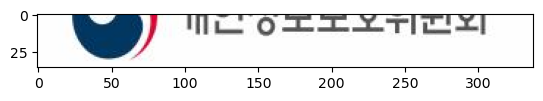

제공된 이미지는 푸른색과 하얀색으로 디자인된 로고입니다. 중앙에는 풍선 모양의 기호가 있고, 아랫부분에는 '대전영생고등학교'라는 한국어 문구가 있습니다. 이 로고는 대전에 위치한 영생고등학교를 상징하는 것으로 보입니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '제공된 이미지는 푸른색과 하얀색으로 디자인된 로고입니다. 중앙에는 풍선 모양의 기호가 있고, 아랫부분에는 '대전영생고등학교'라는 한국어 문구가 있습니다. 이 로고는 대전에 위치한 영생고등학교를 상징하는 것으로 보입니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
5


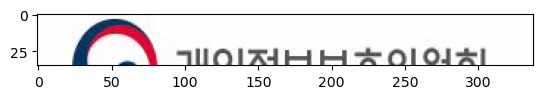

주어진 이미지는 대한민국의 정부 포털 사이트인 '정부24'의 로고를 보여주고 있습니다. 로고는 태극 문양을 포함한 원형 디자인으로, 국가를 상징하는 동시에 열린 정부를 의미합니다. 포털 사이트의 이름인 '정부24'가 로고 아래에 표시되어 있습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 대한민국의 정부 포털 사이트인 '정부24'의 로고를 보여주고 있습니다. 로고는 태극 문양을 포함한 원형 디자인으로, 국가를 상징하는 동시에 열린 정부를 의미합니다. 포털 사이트의 이름인 '정부24'가 로고 아래에 표시되어 있습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
6


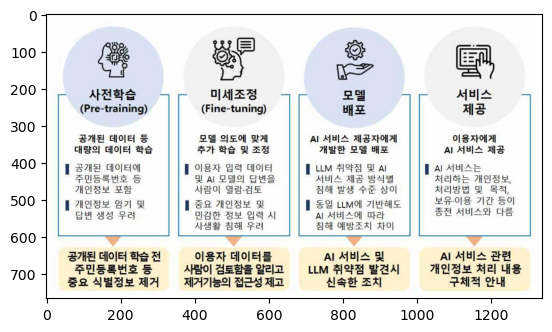

이 이미지는 AI 서비스를 구축하고 제공하는 단계를 설명하고 있습니다. 첫 번째 단계는 사전학습(Pre-training)으로, 공개된 대량의 데이터를 활용하여 모델을 학습시킵니다. 두 번째 단계는 미세조정(Fine-tuning)으로, 특정 업무에 맞게 모델의 지식과 성능을 개선합니다. 세 번째 단계는 모델 배포로, 개발한 AI 모델을 서비스에 배포하여 고객에게 제공할 수 있습니다. 마지막 단계는 서비스 제공으로, AI 서비스를 지속적으로 모니터링하고 개선하여 최적의 서비스를 제공합니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '이 이미지는 AI 서비스를 구축하고 제공하는 단계를 설명하고 있습니다. 첫 번째 단계는 사전학습(Pre-training)으로, 공개된 대량의 데이터를 활용하여 모델을 학습시킵니다. 두 번째 단계는 미세조정(Fine-tuning)으로, 특정 업무에 맞게 모델의 지식과 성능을 개선합니다. 세 번째 단계는 모델 배포로, 개발한 AI 모델을 서비스에 배포하여 고객에게 제공할 수 있습니다. 마지막 단계는 서비스 제공으로, AI 서비스를 지속적으로 모니터링하고 개선하여 최적의 서비스를 제공합니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
7


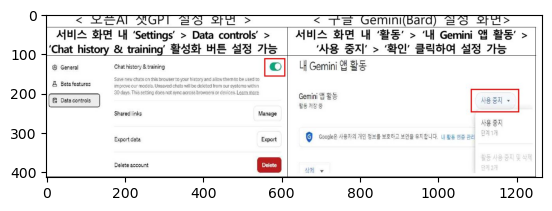

이미지는 Google AI 채팅봇 Gemini(Bard)의 설정 화면을 보여주고 있습니다. 왼쪽에는 일반 설정, 베타 기능, 데이터 관리 등의 옵션이 있고, 오른쪽에는 Gemini 앱 활동 관리, 계정 삭제 등의 옵션이 제공되고 있습니다. 개인정보 보호를 위해 특정 개인이나 단체를 언급하지 않겠습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '이미지는 Google AI 채팅봇 Gemini(Bard)의 설정 화면을 보여주고 있습니다. 왼쪽에는 일반 설정, 베타 기능, 데이터 관리 등의 옵션이 있고, 오른쪽에는 Gemini 앱 활동 관리, 계정 삭제 등의 옵션이 제공되고 있습니다. 개인정보 보호를 위해 특정 개인이나 단체를 언급하지 않겠습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
8


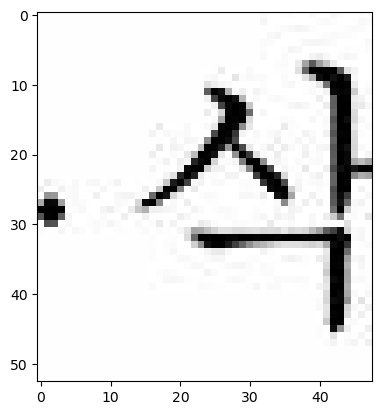

제공된 이미지는 한국어 단어 '식'이 검정색 바탕에 하얀색 한자 글꼴로 크게 적혀있습니다. 이 단어는 '음식' 또는 '밥'을 의미하는 것으로 보입니다. 간결하고 미니멀한 디자인으로, 식(食)이라는 단어 자체에 초점을 맞추고 있습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '제공된 이미지는 한국어 단어 '식'이 검정색 바탕에 하얀색 한자 글꼴로 크게 적혀있습니다. 이 단어는 '음식' 또는 '밥'을 의미하는 것으로 보입니다. 간결하고 미니멀한 디자인으로, 식(食)이라는 단어 자체에 초점을 맞추고 있습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
9


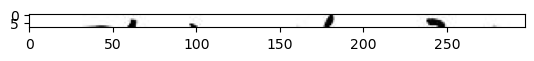

주어진 이미지는 흑백 아동 사진으로 보입니다. 아기와 어린 아이가 나란히 앉아 있는 모습을 담고 있습니다. 아기는 앞치마를 입고 있고, 어린 아이는 머리에 머리끈을 하고 있습니다. 두 아이 모두 카메라를 바라보며 순수한 표정을 짓고 있습니다. 전체적으로 고요하고 평화로운 분위기가 느껴집니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 흑백 아동 사진으로 보입니다. 아기와 어린 아이가 나란히 앉아 있는 모습을 담고 있습니다. 아기는 앞치마를 입고 있고, 어린 아이는 머리에 머리끈을 하고 있습니다. 두 아이 모두 카메라를 바라보며 순수한 표정을 짓고 있습니다. 전체적으로 고요하고 평화로운 분위기가 느껴집니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
10


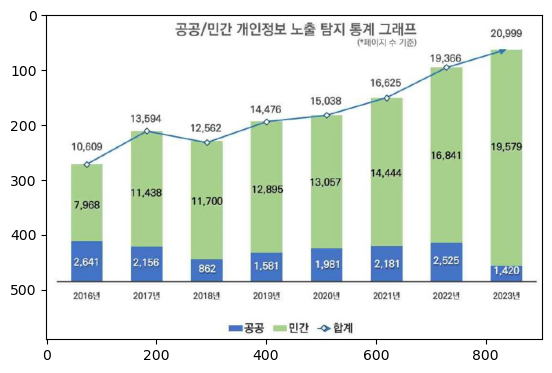

이 그래프는 2016년부터 2023년까지의 공공/민간 개인정보 노출 탐지 통계를 보여주고 있습니다. 민간 분야의 개인정보 노출 건수가 전반적으로 높은 추세를 보이고 있는 반면, 공공 분야의 노출 건수는 상대적으로 낮은 수준을 유지하고 있습니다. 전체적인 개인정보 노출 건수는 2016년 이후 증가세를 보이고 있으나, 2022년에는 소폭 감소하는 모습을 보입니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '이 그래프는 2016년부터 2023년까지의 공공/민간 개인정보 노출 탐지 통계를 보여주고 있습니다. 민간 분야의 개인정보 노출 건수가 전반적으로 높은 추세를 보이고 있는 반면, 공공 분야의 노출 건수는 상대적으로 낮은 수준을 유지하고 있습니다. 전체적인 개인정보 노출 건수는 2016년 이후 증가세를 보이고 있으나, 2022년에는 소폭 감소하는 모습을 보입니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
11


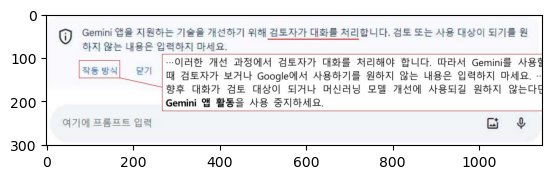

이미지는 Gemini 앱의 서비스에 대해 설명하고 있습니다. 주요 내용으로는 Gemini 앱을 사용하면 개선 과정에서 검토자가 대화를 처리해야 하며, Google에서 사용하기를 원하지 않는 내용은 암호화되어 있다는 점, 그리고 Gemini 앱 활용을 통해 작업을 중지할 수 있다는 내용을 담고 있습니다. 모바일 개선에 사용되길 권장하는 서비스인 것 같습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '이미지는 Gemini 앱의 서비스에 대해 설명하고 있습니다. 주요 내용으로는 Gemini 앱을 사용하면 개선 과정에서 검토자가 대화를 처리해야 하며, Google에서 사용하기를 원하지 않는 내용은 암호화되어 있다는 점, 그리고 Gemini 앱 활용을 통해 작업을 중지할 수 있다는 내용을 담고 있습니다. 모바일 개선에 사용되길 권장하는 서비스인 것 같습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
12


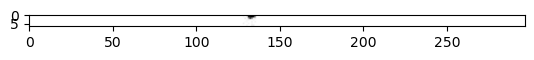

제공된 이미지는 레스토랑 내부의 모습을 보여주고 있습니다. 화려한 샹들리에 조명과 고급스러운 인테리어로 꾸며져 있으며, 테이블에는 깨끗한 식기와 와인잔이 놓여져 있습니다. 고급 레스토랑의 고풍스러우면서도 세련된 분위기를 느낄 수 있습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '제공된 이미지는 레스토랑 내부의 모습을 보여주고 있습니다. 화려한 샹들리에 조명과 고급스러운 인테리어로 꾸며져 있으며, 테이블에는 깨끗한 식기와 와인잔이 놓여져 있습니다. 고급 레스토랑의 고풍스러우면서도 세련된 분위기를 느낄 수 있습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
13


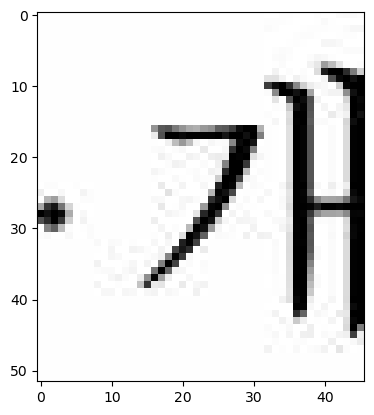

주어진 이미지는 한글 '기린'이라는 단어를 보여줍니다. 글자는 검은색 바탕에 하얀 색상으로 표현되어 있으며, 단순하고 명확한 디자인입니다. 기린은 목이 긴 아프리카 초식 동물입니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 한글 '기린'이라는 단어를 보여줍니다. 글자는 검은색 바탕에 하얀 색상으로 표현되어 있으며, 단순하고 명확한 디자인입니다. 기린은 목이 긴 아프리카 초식 동물입니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
14


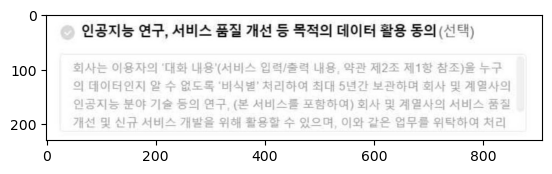

이 이미지는 인공지능 연구, 서비스 품질 개선 등 목적의 데이터 활용 동의에 대해 설명하고 있습니다. 개인정보 보호와 신뢰 서비스 제공을 위해 데이터 활용에 동의할 수 있음을 안내하며, 이런 절차를 거쳐 데이터가 수집되고 활용될 것임을 알리고 있습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '이 이미지는 인공지능 연구, 서비스 품질 개선 등 목적의 데이터 활용 동의에 대해 설명하고 있습니다. 개인정보 보호와 신뢰 서비스 제공을 위해 데이터 활용에 동의할 수 있음을 안내하며, 이런 절차를 거쳐 데이터가 수집되고 활용될 것임을 알리고 있습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
15


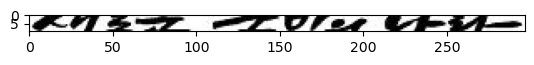

주어진 이미지는 손글씨로 "내가 날아" 라는 텍스트가 적혀있습니다. 글씨체는 조금 거칠고 아마추어 스타일의 필체로 보입니다. 백그라운드는 검은색입니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 손글씨로 "내가 날아" 라는 텍스트가 적혀있습니다. 글씨체는 조금 거칠고 아마추어 스타일의 필체로 보입니다. 백그라운드는 검은색입니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
16


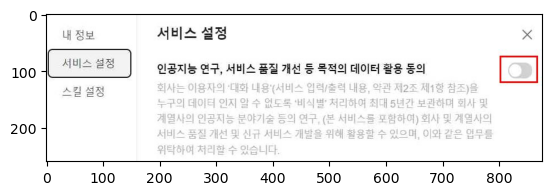

주어진 이미지는 서비스 설정 화면을 보여줍니다. "서비스 설정" 메뉴에서 "인공지능 옵션, 서비스 품질 개선 등 목적의 데이터 활용 동의" 여부를 선택할 수 있는 토글 스위치가 있습니다. 이 옵션은 사용자들이 서비스 품질 개선과 인공지능 모델 학습을 위해 데이터를 수집하고 활용하는 것에 동의하는지 여부를 선택할 수 있게 합니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 서비스 설정 화면을 보여줍니다. "서비스 설정" 메뉴에서 "인공지능 옵션, 서비스 품질 개선 등 목적의 데이터 활용 동의" 여부를 선택할 수 있는 토글 스위치가 있습니다. 이 옵션은 사용자들이 서비스 품질 개선과 인공지능 모델 학습을 위해 데이터를 수집하고 활용하는 것에 동의하는지 여부를 선택할 수 있게 합니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
17


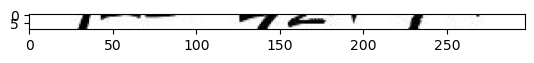

제공된 이미지는 좌측에 'Recommended for you'라는 텍스트와 함께 요리 레시피 영상들이 썸네일로 표시되어 있습니다. 우측에는 '경고' 아이콘과 함께 '대화의 이력이 없습니다. 대화를 시작하려면 메시지를 입력하세요.'라는 안내 문구가 보입니다. 화면 중간에는 대화 창이 있으며, 메시지 입력창과 '보내기' 버튼이 있습니다. 이 이미지는 온라인 채팅 또는 메신저 서비스의 인터페이스를 보여주는 것으로 보입니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '제공된 이미지는 좌측에 'Recommended for you'라는 텍스트와 함께 요리 레시피 영상들이 썸네일로 표시되어 있습니다. 우측에는 '경고' 아이콘과 함께 '대화의 이력이 없습니다. 대화를 시작하려면 메시지를 입력하세요.'라는 안내 문구가 보입니다. 화면 중간에는 대화 창이 있으며, 메시지 입력창과 '보내기' 버튼이 있습니다. 이 이미지는 온라인 채팅 또는 메신저 서비스의 인터페이스를 보여주는 것으로 보입니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
18


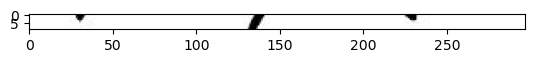

주어진 이미지는 세 명의 남성이 공식적인 행사에 참석한 것으로 보입니다. 그들은 양복을 입고 있으며, 미소를 띠고 있습니다. 중앙의 사람이 어떤 이벤트에서 상을 받은 것 같습니다. 이 사진은 공식적인 행사나 시상식에서 촬영된 것으로 보입니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 세 명의 남성이 공식적인 행사에 참석한 것으로 보입니다. 그들은 양복을 입고 있으며, 미소를 띠고 있습니다. 중앙의 사람이 어떤 이벤트에서 상을 받은 것 같습니다. 이 사진은 공식적인 행사나 시상식에서 촬영된 것으로 보입니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
19


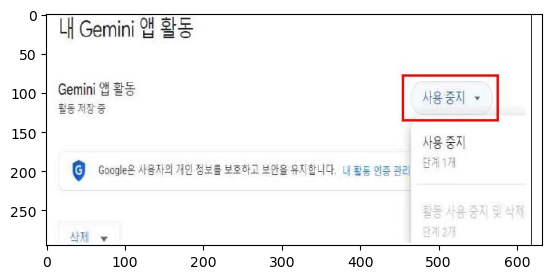

이 이미지는 Gemini 앱 활동을 보여주는 화면 캡처입니다. 구글 계정으로 사용자의 위치를 추적하고 방문한 장소를 기록할 수 있는 기능을 제공합니다. 사용 주기를 선택하는 드롭다운 메뉴와 사용 주기 설명이 포함되어 있습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '이 이미지는 Gemini 앱 활동을 보여주는 화면 캡처입니다. 구글 계정으로 사용자의 위치를 추적하고 방문한 장소를 기록할 수 있는 기능을 제공합니다. 사용 주기를 선택하는 드롭다운 메뉴와 사용 주기 설명이 포함되어 있습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
20


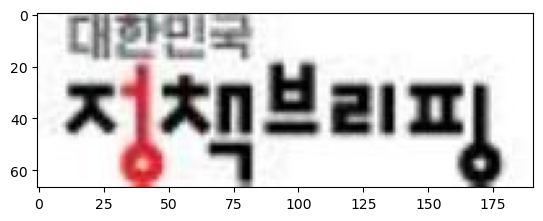

제시된 이미지는 대체 리프트(자체브리핑)라는 한국어 문구가 적혀있는 것으로 보입니다. 흰색 바탕에 검정색 한글 글자로 되어 있으며, 심플하고 간결한 디자인입니다. 구체적인 내용이나 의미는 알 수 없지만, '대체 리프트' 또는 '자체브리핑'과 관련된 것으로 추측됩니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '제시된 이미지는 대체 리프트(자체브리핑)라는 한국어 문구가 적혀있는 것으로 보입니다. 흰색 바탕에 검정색 한글 글자로 되어 있으며, 심플하고 간결한 디자인입니다. 구체적인 내용이나 의미는 알 수 없지만, '대체 리프트' 또는 '자체브리핑'과 관련된 것으로 추측됩니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
21


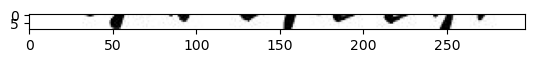

주어진 이미지는 흑백 수화 기호들로 구성되어 있습니다. 사람의 손바닥과 손가락 모양을 통해 수화 기호들이 표현되고 있습니다. 수화 기호들은 청각 장애인들 간의 의사소통을 위해 사용되는 시각적 언어입니다. 이 이미지는 수화 언어의 기본 요소인 손 모양과 움직임, 위치, 표정 등을 보여주고 있습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 흑백 수화 기호들로 구성되어 있습니다. 사람의 손바닥과 손가락 모양을 통해 수화 기호들이 표현되고 있습니다. 수화 기호들은 청각 장애인들 간의 의사소통을 위해 사용되는 시각적 언어입니다. 이 이미지는 수화 언어의 기본 요소인 손 모양과 움직임, 위치, 표정 등을 보여주고 있습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
22


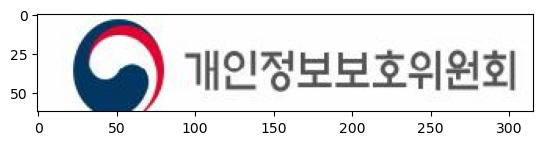

주어진 이미지는 개인정보보호위원회의 로고로 보입니다. 중앙에 나선형의 파란색과 빨간색 아이콘이 있고, 개인정보보호위원회의 한글 명칭이 오른쪽에 있습니다. 로고의 디자인은 개인정보 보호의 개념을 상징적으로 나타내고 있습니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 개인정보보호위원회의 로고로 보입니다. 중앙에 나선형의 파란색과 빨간색 아이콘이 있고, 개인정보보호위원회의 한글 명칭이 오른쪽에 있습니다. 로고의 디자인은 개인정보 보호의 개념을 상징적으로 나타내고 있습니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
23


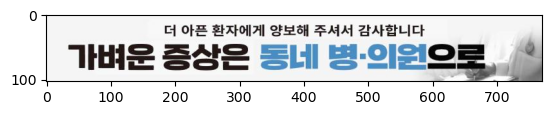

이 이미지는 회색 배경에 한국어로 "더 아픈 환자에게 항보해 주십시오. 가벼운 증상은 증례 병의원으로"라는 문구가 크게 적혀 있습니다. 이는 의료 서비스 이용과 관련된 안내 메시지로 보입니다. 중증 환자와 경증 환자를 구분하여 적절한 의료기관을 이용하도록 권고하는 내용입니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '이 이미지는 회색 배경에 한국어로 "더 아픈 환자에게 항보해 주십시오. 가벼운 증상은 증례 병의원으로"라는 문구가 크게 적혀 있습니다. 이는 의료 서비스 이용과 관련된 안내 메시지로 보입니다. 중증 환자와 경증 환자를 구분하여 적절한 의료기관을 이용하도록 권고하는 내용입니다.'
INFO:retry-bedrock-invocation:trying summary_img() [1/5]



==
24


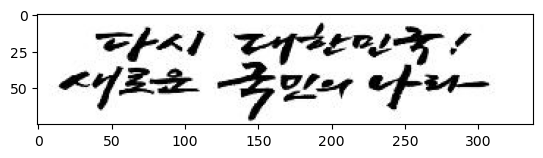

주어진 이미지는 붓글씨로 적힌 한국어 문장입니다. 검은색 먹물로 쓰여진 글씨체는 전통적인 한글 필체를 보여주고 있습니다. 문장 전체의 의미를 정확히 해석하기는 어렵지만, 한국 전통 문화와 관련된 내용으로 추측됩니다.

INFO:retry-bedrock-invocation:in retry(), summary_img() returned '주어진 이미지는 붓글씨로 적힌 한국어 문장입니다. 검은색 먹물로 쓰여진 글씨체는 전통적인 한글 필체를 보여주고 있습니다. 문장 전체의 의미를 정확히 해석하기는 어렵지만, 한국 전통 문화와 관련된 내용으로 추측됩니다.'



==
25


In [42]:
image_summaries = []
for idx, img_base64 in enumerate(img_info):
    summary = summary_img(summarize_chain, img_base64)
    image_summaries.append(summary)
    print ("\n==")
    print (idx)
    
#image_summaries = summarize_chain.batch(img_info, config={"max_concurrency": 1})

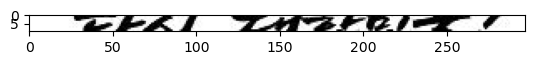

Summary: 주어진 이미지는 전체적으로 검은색 바탕에 "TLTL tztzfzlzz /"라는 흰색 텍스트가 여러 줄로 반복되어 있는 모습입니다. 이미지의 내용이나 의미는 알기 어렵지만 추상적이고 미니멀한 디자인을 보여주고 있습니다. 텍스트의 반복적인 패턴과 단순한 색상 대비로 인해 모던하고 실험적인 예술 작품 같은 인상을 줍니다.


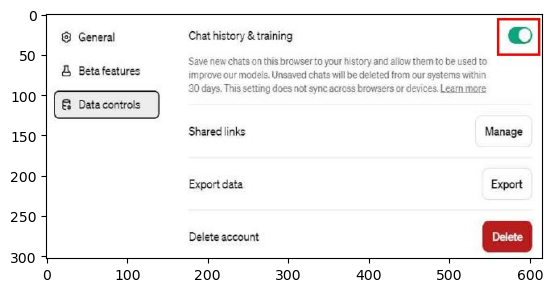

Summary: 주어진 이미지는 AI 채팅 모델의 설정 메뉴를 보여주고 있습니다. 일반, 베타 기능, 데이터 제어 등의 옵션이 있으며, 채팅 내역과 모델 학습 데이터를 저장하거나 공유 링크를 관리할 수 있습니다. 또한 사용자 데이터를 내보내거나 계정을 삭제할 수 있는 옵션도 제공됩니다.


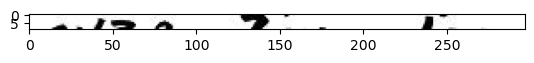

Summary: 주어진 이미지는 한국의 전통 창호문양을 담고 있는 디자인 요소의 모음입니다. 상단에는 반달 모양의 긴 원형 문양과 구름 모양의 장식이 있고, 하단에는 물결 모양의 기하학적 문양과 식물 모티프 등 다양한 전통 문양 요소들이 있습니다. 이러한 한국 전통 미술 양식의 디자인 요소들이 현대적으로 재해석되어 있는 이미지입니다.


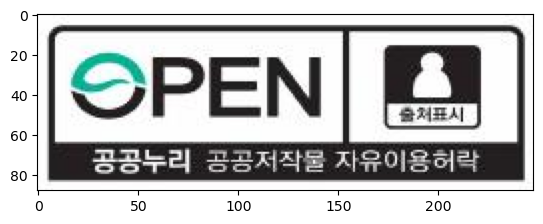

Summary: 주어진 이미지는 한국어와 영어로 "Open"이라는 단어와 함께 상점 영업 시간을 알리는 표지판을 보여주고 있습니다. 녹색과 흰색으로 디자인된 이 표지판은 상점이 현재 영업 중임을 간단명료하게 전달하고 있습니다.


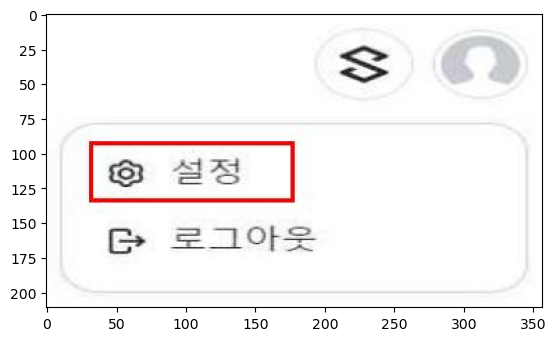

Summary: 이미지는 한국어 설정 메뉴의 일부를 보여주고 있습니다. 설정 아이콘과 "설정" 텍스트가 빨간 상자로 강조되어 있습니다. 이는 사용자가 현재 설정 메뉴에 있음을 나타내는 것으로 보입니다. 또한 모그아웃 옵션도 표시되어 있어 사용자가 로그아웃할 수 있음을 보여줍니다.


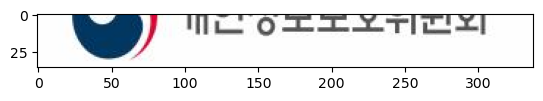

Summary: 제공된 이미지는 푸른색과 하얀색으로 디자인된 로고입니다. 중앙에는 풍선 모양의 기호가 있고, 아랫부분에는 '대전영생고등학교'라는 한국어 문구가 있습니다. 이 로고는 대전에 위치한 영생고등학교를 상징하는 것으로 보입니다.


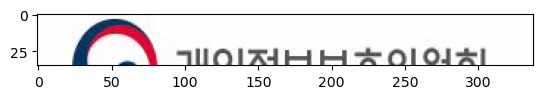

Summary: 주어진 이미지는 대한민국의 정부 포털 사이트인 '정부24'의 로고를 보여주고 있습니다. 로고는 태극 문양을 포함한 원형 디자인으로, 국가를 상징하는 동시에 열린 정부를 의미합니다. 포털 사이트의 이름인 '정부24'가 로고 아래에 표시되어 있습니다.


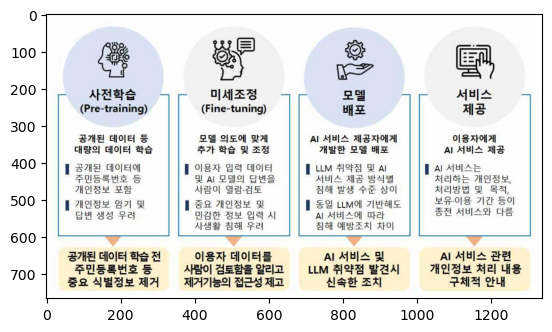

Summary: 이 이미지는 AI 서비스를 구축하고 제공하는 단계를 설명하고 있습니다. 첫 번째 단계는 사전학습(Pre-training)으로, 공개된 대량의 데이터를 활용하여 모델을 학습시킵니다. 두 번째 단계는 미세조정(Fine-tuning)으로, 특정 업무에 맞게 모델의 지식과 성능을 개선합니다. 세 번째 단계는 모델 배포로, 개발한 AI 모델을 서비스에 배포하여 고객에게 제공할 수 있습니다. 마지막 단계는 서비스 제공으로, AI 서비스를 지속적으로 모니터링하고 개선하여 최적의 서비스를 제공합니다.


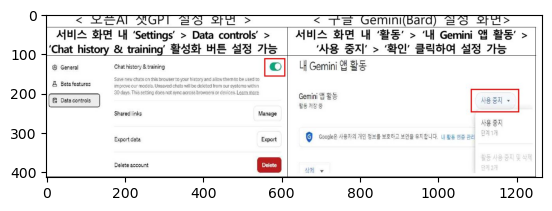

Summary: 이미지는 Google AI 채팅봇 Gemini(Bard)의 설정 화면을 보여주고 있습니다. 왼쪽에는 일반 설정, 베타 기능, 데이터 관리 등의 옵션이 있고, 오른쪽에는 Gemini 앱 활동 관리, 계정 삭제 등의 옵션이 제공되고 있습니다. 개인정보 보호를 위해 특정 개인이나 단체를 언급하지 않겠습니다.


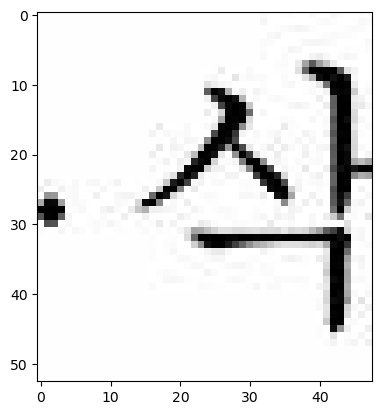

Summary: 제공된 이미지는 한국어 단어 '식'이 검정색 바탕에 하얀색 한자 글꼴로 크게 적혀있습니다. 이 단어는 '음식' 또는 '밥'을 의미하는 것으로 보입니다. 간결하고 미니멀한 디자인으로, 식(食)이라는 단어 자체에 초점을 맞추고 있습니다.


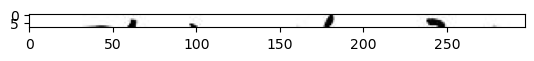

Summary: 주어진 이미지는 흑백 아동 사진으로 보입니다. 아기와 어린 아이가 나란히 앉아 있는 모습을 담고 있습니다. 아기는 앞치마를 입고 있고, 어린 아이는 머리에 머리끈을 하고 있습니다. 두 아이 모두 카메라를 바라보며 순수한 표정을 짓고 있습니다. 전체적으로 고요하고 평화로운 분위기가 느껴집니다.


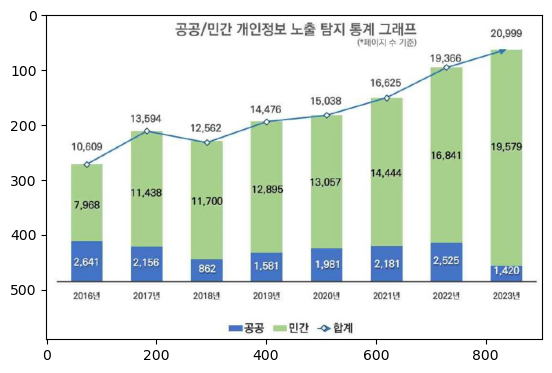

Summary: 이 그래프는 2016년부터 2023년까지의 공공/민간 개인정보 노출 탐지 통계를 보여주고 있습니다. 민간 분야의 개인정보 노출 건수가 전반적으로 높은 추세를 보이고 있는 반면, 공공 분야의 노출 건수는 상대적으로 낮은 수준을 유지하고 있습니다. 전체적인 개인정보 노출 건수는 2016년 이후 증가세를 보이고 있으나, 2022년에는 소폭 감소하는 모습을 보입니다.


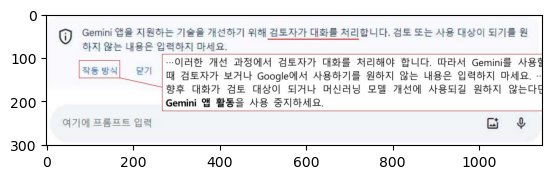

Summary: 이미지는 Gemini 앱의 서비스에 대해 설명하고 있습니다. 주요 내용으로는 Gemini 앱을 사용하면 개선 과정에서 검토자가 대화를 처리해야 하며, Google에서 사용하기를 원하지 않는 내용은 암호화되어 있다는 점, 그리고 Gemini 앱 활용을 통해 작업을 중지할 수 있다는 내용을 담고 있습니다. 모바일 개선에 사용되길 권장하는 서비스인 것 같습니다.


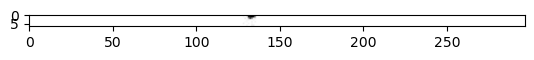

Summary: 제공된 이미지는 레스토랑 내부의 모습을 보여주고 있습니다. 화려한 샹들리에 조명과 고급스러운 인테리어로 꾸며져 있으며, 테이블에는 깨끗한 식기와 와인잔이 놓여져 있습니다. 고급 레스토랑의 고풍스러우면서도 세련된 분위기를 느낄 수 있습니다.


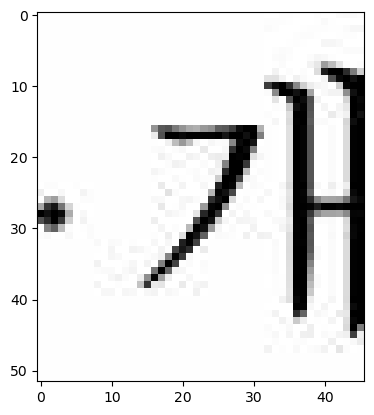

Summary: 주어진 이미지는 한글 '기린'이라는 단어를 보여줍니다. 글자는 검은색 바탕에 하얀 색상으로 표현되어 있으며, 단순하고 명확한 디자인입니다. 기린은 목이 긴 아프리카 초식 동물입니다.


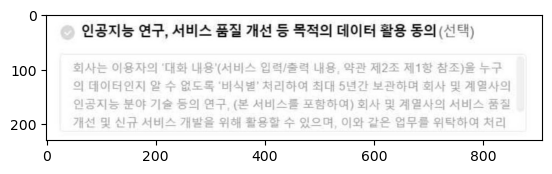

Summary: 이 이미지는 인공지능 연구, 서비스 품질 개선 등 목적의 데이터 활용 동의에 대해 설명하고 있습니다. 개인정보 보호와 신뢰 서비스 제공을 위해 데이터 활용에 동의할 수 있음을 안내하며, 이런 절차를 거쳐 데이터가 수집되고 활용될 것임을 알리고 있습니다.


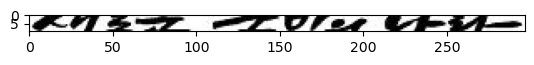

Summary: 주어진 이미지는 손글씨로 "내가 날아" 라는 텍스트가 적혀있습니다. 글씨체는 조금 거칠고 아마추어 스타일의 필체로 보입니다. 백그라운드는 검은색입니다.


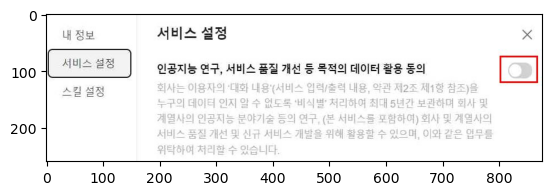

Summary: 주어진 이미지는 서비스 설정 화면을 보여줍니다. "서비스 설정" 메뉴에서 "인공지능 옵션, 서비스 품질 개선 등 목적의 데이터 활용 동의" 여부를 선택할 수 있는 토글 스위치가 있습니다. 이 옵션은 사용자들이 서비스 품질 개선과 인공지능 모델 학습을 위해 데이터를 수집하고 활용하는 것에 동의하는지 여부를 선택할 수 있게 합니다.


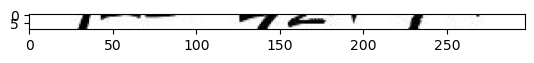

Summary: 제공된 이미지는 좌측에 'Recommended for you'라는 텍스트와 함께 요리 레시피 영상들이 썸네일로 표시되어 있습니다. 우측에는 '경고' 아이콘과 함께 '대화의 이력이 없습니다. 대화를 시작하려면 메시지를 입력하세요.'라는 안내 문구가 보입니다. 화면 중간에는 대화 창이 있으며, 메시지 입력창과 '보내기' 버튼이 있습니다. 이 이미지는 온라인 채팅 또는 메신저 서비스의 인터페이스를 보여주는 것으로 보입니다.


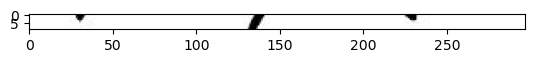

Summary: 주어진 이미지는 세 명의 남성이 공식적인 행사에 참석한 것으로 보입니다. 그들은 양복을 입고 있으며, 미소를 띠고 있습니다. 중앙의 사람이 어떤 이벤트에서 상을 받은 것 같습니다. 이 사진은 공식적인 행사나 시상식에서 촬영된 것으로 보입니다.


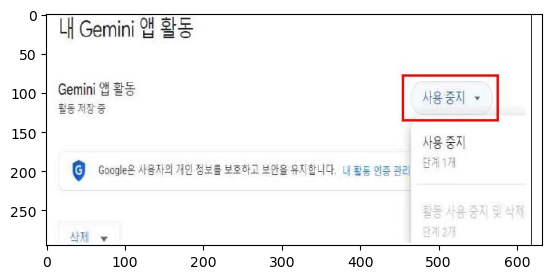

Summary: 이 이미지는 Gemini 앱 활동을 보여주는 화면 캡처입니다. 구글 계정으로 사용자의 위치를 추적하고 방문한 장소를 기록할 수 있는 기능을 제공합니다. 사용 주기를 선택하는 드롭다운 메뉴와 사용 주기 설명이 포함되어 있습니다.


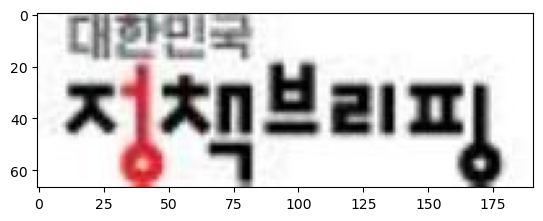

Summary: 제시된 이미지는 대체 리프트(자체브리핑)라는 한국어 문구가 적혀있는 것으로 보입니다. 흰색 바탕에 검정색 한글 글자로 되어 있으며, 심플하고 간결한 디자인입니다. 구체적인 내용이나 의미는 알 수 없지만, '대체 리프트' 또는 '자체브리핑'과 관련된 것으로 추측됩니다.


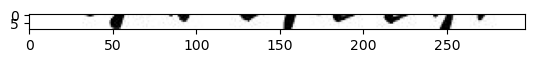

Summary: 주어진 이미지는 흑백 수화 기호들로 구성되어 있습니다. 사람의 손바닥과 손가락 모양을 통해 수화 기호들이 표현되고 있습니다. 수화 기호들은 청각 장애인들 간의 의사소통을 위해 사용되는 시각적 언어입니다. 이 이미지는 수화 언어의 기본 요소인 손 모양과 움직임, 위치, 표정 등을 보여주고 있습니다.


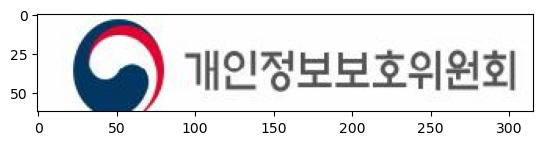

Summary: 주어진 이미지는 개인정보보호위원회의 로고로 보입니다. 중앙에 나선형의 파란색과 빨간색 아이콘이 있고, 개인정보보호위원회의 한글 명칭이 오른쪽에 있습니다. 로고의 디자인은 개인정보 보호의 개념을 상징적으로 나타내고 있습니다.


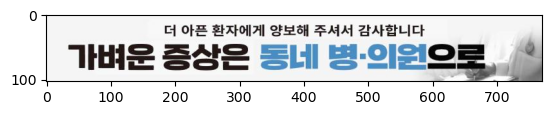

Summary: 이 이미지는 회색 배경에 한국어로 "더 아픈 환자에게 항보해 주십시오. 가벼운 증상은 증례 병의원으로"라는 문구가 크게 적혀 있습니다. 이는 의료 서비스 이용과 관련된 안내 메시지로 보입니다. 중증 환자와 경증 환자를 구분하여 적절한 의료기관을 이용하도록 권고하는 내용입니다.


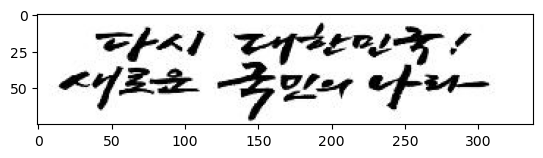

Summary: 주어진 이미지는 붓글씨로 적힌 한국어 문장입니다. 검은색 먹물로 쓰여진 글씨체는 전통적인 한글 필체를 보여주고 있습니다. 문장 전체의 의미를 정확히 해석하기는 어렵지만, 한국 전통 문화와 관련된 내용으로 추측됩니다.


In [43]:
verbose = True
if verbose:
    for img_base64, summary in zip(img_info, image_summaries):

        print ("============================")
        img = Image.open(BytesIO(base64.b64decode(img_base64)))
        plt.imshow(img)
        plt.show()

        print (f'Summary: {summary}')

`요약`된 내용을 Document의 `page_content`로, `OCR`결과는 metadata의 `origin_image`로 사용

In [44]:
images_preprocessed = []

for img_path, image_base64, summary in zip(images, img_info, image_summaries):
    
    metadata = {}
    metadata["img_path"] = img_path
    metadata["category"] = "Image"
    metadata["image_base64"] = image_base64
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    images_preprocessed.append(doc)

### For tables

In [45]:
human_prompt = [
    {
        "type": "text",
        "text": '''
                 Here is the table: <table>{table}</table>
                 Given table, give a concise summary.
                 Don't insert any XML tag such as <table> and </table> when answering.
                 Write in Korean.
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

In [46]:
prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)

#summarize_chain = prompt | llm_text | StrOutputParser()
summarize_chain = {"table": lambda x:x} | prompt | llm_text | StrOutputParser()

In [47]:
if table_by_llama_parse and table_by_pymupdf:
    tables = tables + docs_table_llamaparse + docs_table_pymupdf
elif table_by_llama_parse:
    tables = tables + docs_table_llamaparse
elif table_by_pymupdf:
    tables = tables + docs_table_pymupdf

In [48]:
table_info = [(t.page_content, t.metadata["text_as_html"]) for t in tables]
table_summaries = summarize_chain.batch(table_info, config={"max_concurrency": 1})
if table_as_image: table_info = [(t.page_content, t.metadata["text_as_html"], t.metadata["image_base64"]) if "image_base64" in t.metadata else (t.page_content, t.metadata["text_as_html"], None) for t in tables]

주어진 표는 개인정보 유출 건수를 유형별로 나타내고 있습니다. 전화번호 유출이 672건으로 가장 많았고, 이메일주소 142건, 여권번호 34건, 주민등록번호 2건 순으로 나타납니다. 총 유출 건수는 850건입니다.이 표는 개인정보보호 관련 기관들의 담당 부서와 역할, 연락처 정보를 제공하고 있습니다. 개인정보보호위원회 내 조사1과, 조사3팀, 인공지능프라이버시팀, 그리고 한국인터넷진흥원 기업조사팀의 책임자와 담당자, 연락처가 안내되어 있습니다. 개인정보 보호 관련 문의나 상담이 필요한 경우 이 연락처를 활용할 수 있겠습니다.이 표는 AI 기업들의 개인정보 보호 노력을 요약하고 있습니다. OpenAI, Google, Meta, 네이버, MS 등의 기업들이 학습 데이터에서 개인정보를 제거하고, 개인정보 노출 페이지를 차단하며, 부적절한 답변을 신고할 수 있는 기능을 제공하는 등 개인정보 보호를 위해 노력하고 있음을 보여줍니다.제시된 표는 개인정보 유출 건수를 구분별로 나타내고 있습니다. 주소, 전화번호, 이메일, SNS 등의 개인정보와 건강보험번호, 계좌번호, 신용카드번호 등의 금융정보 유출 건수를 보여주고 있습니다. 총 520건의 개인정보 유출 사례가 있었음을 알 수 있습니다.

In [49]:
from utils.common_utils import print_html

0
table: 구분 건수 구분 건수 전화번호 672 주민등록번호 2 이메일주소 142 여권번호 34 합계 850
----------------------------
summary: 주어진 표는 개인정보 유출 건수를 유형별로 나타내고 있습니다. 전화번호 유출이 672건으로 가장 많았고, 이메일주소 142건, 여권번호 34건, 주민등록번호 2건 순으로 나타납니다. 총 유출 건수는 850건입니다.
----------------------------
html:


전 화 번 호,672,주 민 등 록 번 호,2
이 메 일 주 소,142,여 권 번 호,34
,,합 계,850


----------------------------
image


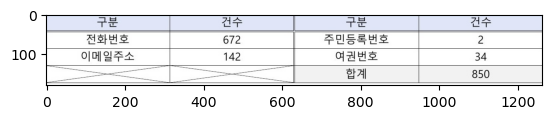

1
table: 담당 부서 <총 괄> 개인정보보호위원회 조사1과 책임자 담당자 과 장 사무관 강대현 (02-2100-3111) 고명석 (02-2100-3114) <공 동> 개인정보보호위원회 조사3팀 책임자 담당자 팀 장 사무관 전승재 (02-2100-3151) 서인숙 (02-2100-3154) <공 동> 개인정보보호위원회 책임자 (代)팀 장 태현수 (02-2100-3071) 인공지능프라이버시팀 담당자 사무관 구민주 (02-2100-3073) <공 동> 한국인터넷진흥원 기업조사팀 책임자 담당자 팀 장 선임연구원 박대식 (061-820-1113) 최진경 (061-820-1939)
----------------------------
summary: 이 표는 개인정보보호 관련 기관들의 담당 부서와 역할, 연락처 정보를 제공하고 있습니다. 개인정보보호위원회 내 조사1과, 조사3팀, 인공지능프라이버시팀, 그리고 한국인터넷진흥원 기업조사팀의 책임자와 담당자, 연락처가 안내되어 있습니다. 개인정보 보호 관련 문의나 상담이 필요한 경우 이 연락처를 활용할 수 있겠습니다.
----------------------------
html:


서 l〈/ 과 & 종,띠 레 애 아 어 퍼 o bt Mo ~N,K ol 헬,KO,운 — | 우 노 위 띠 B = 80
,", 더 도 풋 S N",넋 |,| A o+ A<,[ 하 | [ ool OO0 [ 위 | 여 OO0l M| 0 더
^ | o 10,I |w 해 | 아 | 어 | 퍼 et Mo ~N,K 1040]|00]100]600 |,10 (ul|<,은 ㅜ 아이 ||~ ] 우 T (<o |
,. 빨 오 궁 oo O,넋 F|U0|,| ™| o+,|[ 호 OO 는 이 ] 위 NN |4 | ol 1
^ 0 10,- el | 어 | 퍼 o Mo ~N,K,K0 |ul > £,[ 은 | 으 우 |—|— ] 이 |<F 101 | T
,g 8추 우 스 오 띠 | O O = 인,넋 00]| U0,™| o+ <,으 우1 으 느 위 바 Tl |
^ 0 10,| | 00 | | | X 크 e |,K ||,KO |uwl|,ool N~ ㅜ | 으 O|d |0 ] 곤 OO 0 ol
,_ 끼 K 버 D e ~,넋 001400 W0,|of + 3] ol 7,| 으 1 | 으 | | [운 OO | O 180 Kl | &


----------------------------
image


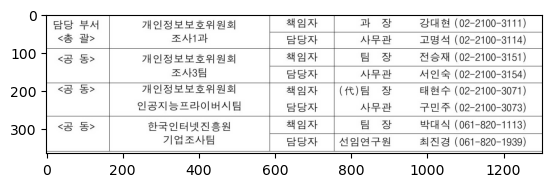

2
table: 구분 주요내용 • OpenAI, OpCo LLC • Google LLC 개인정보에 대해 강화된 보호 • Meta Platforms, Inc ※ 한국 정보주체의 개인정보 노출 페이지(URL)에 대한 삭제‧차단 정보 반영 등 • 네이버 • 뤼튼 노력 • MS • OpenAI, OpCo LLC • Google LLC 신속 대응
----------------------------
summary: 이 표는 AI 기업들의 개인정보 보호 노력을 요약하고 있습니다. OpenAI, Google, Meta, 네이버, MS 등의 기업들이 학습 데이터에서 개인정보를 제거하고, 개인정보 노출 페이지를 차단하며, 부적절한 답변을 신고할 수 있는 기능을 제공하는 등 개인정보 보호를 위해 노력하고 있음을 보여줍니다.
----------------------------
html:


----------------------------
image


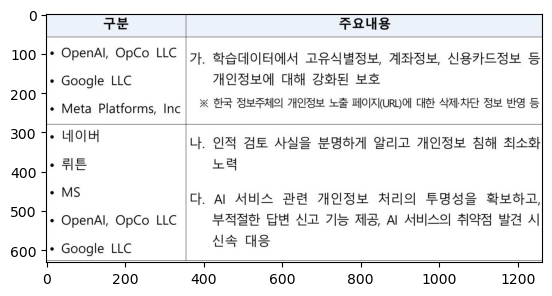

3
table: 구분 건수 구분 건수 주소 전화번호 이메일 SNS 222 111 106 78 건강보험번호 계좌번호 신용카드번호 합계 1 1 1 520
----------------------------
summary: 제시된 표는 개인정보 유출 건수를 구분별로 나타내고 있습니다. 주소, 전화번호, 이메일, SNS 등의 개인정보와 건강보험번호, 계좌번호, 신용카드번호 등의 금융정보 유출 건수를 보여주고 있습니다. 총 520건의 개인정보 유출 사례가 있었음을 알 수 있습니다.
----------------------------
html:


주 소,222,건 강 보 험 번 호,
전 화 번 호,111,계 좌 번 호,
이 메 일,106,신 용 카 드 번 호,
SNS,78,,520


----------------------------
image


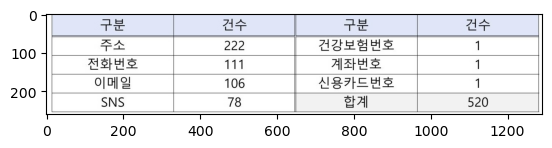

In [50]:
verbose = True
index = 0
if verbose:
    for table, summary in zip(table_info, table_summaries):

        if table_as_image:
            page_contents, table_as_html, img_base64 = table
        else: page_contents, table_as_html = table

        print ("============================")
        print (index)
        print (f'table: {page_contents}')
        print ("----------------------------")
        print (f'summary: {summary}')
        print ("----------------------------")
        print (f'html:')
        print_html(table_as_html)
        print ("----------------------------")
        if table_as_image and img_base64 is not None:
            print ("image")
            img = Image.open(BytesIO(base64.b64decode(img_base64)))
            plt.imshow(img)
            plt.show()
        index += 1


`요약`된 내용을 Document의 `page_content`로, `parsed table`은 metadata의 `origin_table`로 사용

In [51]:
tables_preprocessed = []

for origin, summary in zip(tables, table_summaries):
    metadata = origin.metadata
    metadata["origin_table"] = origin.page_content
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    tables_preprocessed.append(doc)
    
#tables_preprocessed, images_preprocessed


In [52]:
#to_pickle(tables_preprocessed, "./data/complex_pdf/pickle/tables_preprocessed.pkl")
#to_pickle(images_preprocessed, "./data/complex_pdf/pickle/images_preprocessed.pkl")
#docs = load_pickle("./data/complex_pdf/pickle/parsed_unstructured.pkl")

In [53]:
#tables_preprocessed = load_pickle("./data/complex_pdf/pickle/tables_preprocessed.pkl")
#images_preprocessed = load_pickle("./data/complex_pdf/pickle/images_preprocessed.pkl")

## 4. Index 생성

### Index 이름 결정

In [54]:
import boto3
from utils.ssm import parameter_store

In [55]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [57]:
#index_name = "kb_complex_doc"
#index_name = "summit-workshop-index" #summit-workshop-index-unstructured, #summit-workshop-index-unstructured-pymupdf, summit-workshop-index-unstructured-pymupdf-llama
index_name = "default_doc_index"

In [58]:
pm.put_params(
    key="opensearch_index_name",
    value=f'{index_name}',
    overwrite=True,
    enc=False
)

Parameter stored successfully.


### Index 스키마 정의

In [59]:
index_body = {
    'settings': {
        'analysis': {
            'analyzer': {
                'my_analyzer': {
                         'char_filter':['html_strip'],
                    'tokenizer': 'nori',
                    'filter': [
                        #'nori_number',
                        #'lowercase',
                        #'trim',
                        'my_nori_part_of_speech'
                    ],
                    'type': 'custom'
                }
            },
            'tokenizer': {
                'nori': {
                    'decompound_mode': 'mixed',
                    'discard_punctuation': 'true',
                    'type': 'nori_tokenizer'
                }
            },
            "filter": {
                "my_nori_part_of_speech": {
                    "type": "nori_part_of_speech",
                    "stoptags": [
                        "J", "XSV", "E", "IC","MAJ","NNB",
                        "SP", "SSC", "SSO",
                        "SC","SE","XSN","XSV",
                        "UNA","NA","VCP","VSV",
                        "VX"
                    ]
                }
            }
        },
        'index': {
            'knn': True,
            'knn.space_type': 'cosinesimil'  # Example space type
        }
    },
    'mappings': {
        'properties': {
            'metadata': {
                'properties': {
                    'source': {'type': 'keyword'},
                    'page_number': {'type':'long'},
                    'category': {'type':'text'},
                    'file_directory': {'type':'text'},
                    'last_modified': {'type': 'text'},
                    'type': {'type': 'keyword'},
                    'image_base64': {'type':'text'},
                    'origin_image': {'type':'text'},
                    'origin_table': {'type':'text'},
                }
            },
            'text': {
                'analyzer': 'my_analyzer',
                'search_analyzer': 'my_analyzer',
                'type': 'text'
            },
            'vector_field': {
                'type': 'knn_vector',
                'dimension': f"{dimension}" # Replace with your vector dimension
            }
        }
    }
}


## 5. LangChain OpenSearch VectorStore 생성 
### 선수 조건

#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.

In [60]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

#opensearch_user_password = pm.get_params(
#    key="opensearch_user_password",
#    enc=True
#)

In [80]:
secrets_manager = boto3.client('secretsmanager')

response = secrets_manager.get_secret_value(
    SecretId='opensearch_user_password'
)

secrets_string = response.get('SecretString')
secrets_dict = eval(secrets_string)
opensearch_user_password= list(secrets_dict.values())[0]

In [81]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### OpenSearch Client 생성

In [82]:
from utils.opensearch import opensearch_utils

In [83]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)

os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

### 오픈 서치 인덱스 생성 
- 오픈 서치에 해당 인덱스가 존재하면, 삭제 합니다. 

In [84]:
index_exists = opensearch_utils.check_if_index_exists(
    os_client,
    index_name
)

if index_exists:
    opensearch_utils.delete_index(
        os_client,
        index_name
    )

opensearch_utils.create_index(os_client, index_name, index_body)
index_info = os_client.indices.get(index=index_name)
print("Index is created")
pprint(index_info)

index_name=llm_usage_report, exists=False

Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'llm_usage_report'}
Index is created
{'llm_usage_report': {'aliases': {},
                      'mappings': {'properties': {'metadata': {'properties': {'category': {'type': 'text'},
                                                                              'file_directory': {'type': 'text'},
                                                                              'image_base64': {'type': 'text'},
                                                                              'last_modified': {'type': 'text'},
                                                                              'origin_image': {'type': 'text'},
                                                                              'origin_table': {'type': 'text'},
                                                                              'page_number': {'type': 'long'},
                        

### 랭체인 인덱스 연결 오브젝트 생성

- [langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.opensearch_vector_search.OpenSearchVectorSearch.html)

In [85]:
from langchain.vectorstores import OpenSearchVectorSearch

In [86]:
vector_db = OpenSearchVectorSearch(
    index_name=index_name,
    opensearch_url=opensearch_domain_endpoint,
    embedding_function=llm_emb,
    http_auth=http_auth, # http_auth
    is_aoss=False,
    engine="faiss",
    space_type="l2",
    bulk_size=100000,
    timeout=60
)
vector_db

### Chunking Strategy: Parent documents
* Chunk Size and Chunk Overlap Size

In [87]:
from utils.chunk import parant_documents

In [88]:
parent_chunk_size = 4096
parent_chunk_overlap = 0

child_chunk_size = 1024
child_chunk_overlap = 256

opensearch_parent_key_name = "parent_id"
opensearch_family_tree_key_name = "family_tree"

* Parent Chunking
    - create_parent_chunk() 아래와 같은 작업을 합니다.
    - all_docs 에 있는 문서를 parent_chunk_size 만큼으로 청킹 합니다.
    - Parent Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: parent
        - parent_id : None

In [89]:
parent_chunk_docs = parant_documents.create_parent_chunk(
    docs=texts,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name,
    parent_chunk_size=parent_chunk_size,
    parent_chunk_overlap=parent_chunk_overlap
)
print(f'Number of parent_chunk_docs= {len(parent_chunk_docs)}')

Number of parent_chunk_docs= 5


* Insert doc into OpenSearch 

In [90]:
%%time

parent_ids = vector_db.add_documents(
    documents = parent_chunk_docs, 
    vector_field = "vector_field",
    bulk_size = 1000000
)

CPU times: user 39.9 ms, sys: 0 ns, total: 39.9 ms
Wall time: 1.33 s


In [91]:
total_count_docs = opensearch_utils.get_count(os_client, index_name)
print("total count docs: ", total_count_docs)

total count docs:  {'count': 5, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}


* 삽입된 Parent Chunk 의 첫번째를 확인 합니다. family_tree, parent_id 의 값을 확인 하세요.

In [92]:
def show_opensearch_doc_info(response):
    print("opensearch document id:" , response["_id"])
    print("family_tree:" , response["_source"]["metadata"]["family_tree"])
    print("parent document id:" , response["_source"]["metadata"]["parent_id"])
    print("parent document text: \n" , response["_source"]["text"])

response = opensearch_utils.get_document(os_client, doc_id = parent_ids[0], index_name = index_name)
show_opensearch_doc_info(response)

opensearch document id: 99545fda-51bb-4bef-a497-f2e4cb9ac898
family_tree: parent
parent document id: None
parent document text: 
 Q Q 개 인 정 보 보 호 위 원 회 개 인 정 보 보 호 위 원 회 개인정보보호위원회 보도자료 .J,’_{;’ %‘Ljﬁ":’f‘;'_ 보도시점 2024. 3. 28.(목) 12:00 배포 2024. 3. 28.(목) 07:40 개인정보위, 주요 인공지능(AI) 서비스 사전 실태점검 결과 발표 - LLM(Large Language Model) 사업자에 대해 학습 과정 및 서비스 관련 개선권고 ∙공개된 데이터 학습시 주민번호 등 중요 개인 식별정보 제거 노력 강화 (KISA 제공 「한국 정보주체의 개인정보 노출 페이지(URL 등) 삭제‧차단 정보」 반영) ∙이용자 입력 데이터의 학습‧이용 관련 안내 및 개인정보 침해 최소화 노력 강화 ∙개인정보 처리방침 구체화 및 취약점 발견시 신속 대응 개인정보보호위원회(위원장 고학수, 이하 ‘개인정보위’)는 3월 27일(수) 제6회 전체회의를 열고, 대규모 언어 모델(Large Language Model, 이하 ‘LLM’)을 개발‧배포하거나 이를 기반으로 인공지능(AI) 서비스를 제공하는 6개 사업자에 대하여 개인정보 보호의 취약점을 보완하도록 개선권고를 의결하였다. ※ (LLM 관련) 오픈AI / 구글 / MS / 메타 / 네이버 / 뤼튼 (응용서비스(B2C‧B2B) 관련) 5개 내외 사업자 → 추후 발표 개인정보위는 초거대‧생성형 AI 서비스의 급속 확산으로 프라이버시 침해 우려가 증대됨에 따라, 국민 불안의 조기 해소와 안전한 서비스 활성화를 위해 지난해 11월부터 한국인터넷진흥원(원장 이상중)과 함께 주요 AI 서비스를 대상으로 사전 실태점검을 진행하였다. AI 단계별 개인정보 보호의 취약점 점검 결과, 전반적으로 개인정보 처리 방침 공개, 데이터 전처리, 정보주체의 통제권 보장 등 보

* Child Chunking
    - 아래의 create_child_chunk() 는 다음과 같은 작업을 합니다.
    - parent_chunk_docs 각각에 대해서 Child Chunk 를 생성 합니다. 
    - Child Chunk 에 두개의 메타 데이타를 생성 합니다.
        - family_tree: child
        - parent_id : parent 에 대한 OpenSearch document id

In [93]:
# child_chunk_docs = create_child_chunk(parent_chunk_docs[0:1], parent_ids)
child_chunk_docs = parant_documents.create_child_chunk(
    child_chunk_size=child_chunk_size,
    child_chunk_overlap=child_chunk_overlap,
    docs=parent_chunk_docs,
    parent_ids_value=parent_ids,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name
)

print(f"Number of child_chunk_docs= {len(child_chunk_docs)}")

Number of child_chunk_docs= 9


In [94]:
parent_id = child_chunk_docs[0].metadata["parent_id"]
print("child's parent_id: ", parent_id)
print("\n###### Search parent in OpenSearch")
response = opensearch_utils.get_document(os_client, doc_id = parent_id, index_name = index_name)
show_opensearch_doc_info(response)    

child's parent_id:  99545fda-51bb-4bef-a497-f2e4cb9ac898

###### Search parent in OpenSearch
opensearch document id: 99545fda-51bb-4bef-a497-f2e4cb9ac898
family_tree: parent
parent document id: None
parent document text: 
 Q Q 개 인 정 보 보 호 위 원 회 개 인 정 보 보 호 위 원 회 개인정보보호위원회 보도자료 .J,’_{;’ %‘Ljﬁ":’f‘;'_ 보도시점 2024. 3. 28.(목) 12:00 배포 2024. 3. 28.(목) 07:40 개인정보위, 주요 인공지능(AI) 서비스 사전 실태점검 결과 발표 - LLM(Large Language Model) 사업자에 대해 학습 과정 및 서비스 관련 개선권고 ∙공개된 데이터 학습시 주민번호 등 중요 개인 식별정보 제거 노력 강화 (KISA 제공 「한국 정보주체의 개인정보 노출 페이지(URL 등) 삭제‧차단 정보」 반영) ∙이용자 입력 데이터의 학습‧이용 관련 안내 및 개인정보 침해 최소화 노력 강화 ∙개인정보 처리방침 구체화 및 취약점 발견시 신속 대응 개인정보보호위원회(위원장 고학수, 이하 ‘개인정보위’)는 3월 27일(수) 제6회 전체회의를 열고, 대규모 언어 모델(Large Language Model, 이하 ‘LLM’)을 개발‧배포하거나 이를 기반으로 인공지능(AI) 서비스를 제공하는 6개 사업자에 대하여 개인정보 보호의 취약점을 보완하도록 개선권고를 의결하였다. ※ (LLM 관련) 오픈AI / 구글 / MS / 메타 / 네이버 / 뤼튼 (응용서비스(B2C‧B2B) 관련) 5개 내외 사업자 → 추후 발표 개인정보위는 초거대‧생성형 AI 서비스의 급속 확산으로 프라이버시 침해 우려가 증대됨에 따라, 국민 불안의 조기 해소와 안전한 서비스 활성화를 위해 지난해 11월부터 한국인터넷진흥원(원장 이상중)과 함께 주요 AI 서비스를 대

In [95]:
child_chunk_docs[0]

Document(page_content='Q Q 개 인 정 보 보 호 위 원 회 개 인 정 보 보 호 위 원 회 개인정보보호위원회 보도자료 .J,’_{;’ %‘Ljﬁ":’f‘;\'_ 보도시점 2024. 3. 28.(목) 12:00 배포 2024. 3. 28.(목) 07:40 개인정보위, 주요 인공지능(AI) 서비스 사전 실태점검 결과 발표 - LLM(Large Language Model) 사업자에 대해 학습 과정 및 서비스 관련 개선권고 ∙공개된 데이터 학습시 주민번호 등 중요 개인 식별정보 제거 노력 강화 (KISA 제공 「한국 정보주체의 개인정보 노출 페이지(URL 등) 삭제‧차단 정보」 반영) ∙이용자 입력 데이터의 학습‧이용 관련 안내 및 개인정보 침해 최소화 노력 강화 ∙개인정보 처리방침 구체화 및 취약점 발견시 신속 대응 개인정보보호위원회(위원장 고학수, 이하 ‘개인정보위’)는 3월 27일(수) 제6회 전체회의를 열고, 대규모 언어 모델(Large Language Model, 이하 ‘LLM’)을 개발‧배포하거나 이를 기반으로 인공지능(AI) 서비스를 제공하는 6개 사업자에 대하여 개인정보 보호의 취약점을 보완하도록 개선권고를 의결하였다. ※ (LLM 관련) 오픈AI / 구글 / MS / 메타 / 네이버 / 뤼튼 (응용서비스(B2C‧B2B) 관련) 5개 내외 사업자 → 추후 발표 개인정보위는 초거대‧생성형 AI 서비스의 급속 확산으로 프라이버시 침해 우려가 증대됨에 따라, 국민 불안의 조기 해소와 안전한 서비스 활성화를 위해 지난해 11월부터 한국인터넷진흥원(원장 이상중)과 함께 주요 AI 서비스를 대상으로 사전 실태점검을 진행하였다. AI 단계별 개인정보 보호의 취약점 점검 결과, 전반적으로 개인정보 처리 방침 공개, 데이터 전처리, 정보주체의 통제권 보장 등 보호법상 기본적 요건을 대체로 충족하였으나, 세부적으로 ①공개된 데이터에 포함된 개인정보 처리, ②이용자 입력 데이터 등의 처리, ③개인정보 침해 예방‧대응 조치 및 투명성 등 관련하여 일부 

### Manipulate table and image for parent documents
- set family_tree of table and image documents as "parent_table" and these kinds of types are included in searcable list (child, parent_table and parent_image) in parant document strategy.

In [96]:
for table in tables_preprocessed:
    table.metadata["family_tree"], table.metadata["parent_id"] = "parent_table", "NA"

In [97]:
for image in images_preprocessed:
    image.metadata["family_tree"], image.metadata["parent_id"] = "parent_image", "NA"

### Merge text, table and image

In [98]:
from itertools import chain

In [99]:
docs_preprocessed = list(chain(child_chunk_docs, tables_preprocessed, images_preprocessed))

In [100]:
docs_preprocessed = list(chain(images_preprocessed))

In [101]:
images_preprocessed[0]

Document(page_content='주어진 이미지는 전체적으로 검은색 바탕에 "TLTL tztzfzlzz /"라는 흰색 텍스트가 여러 줄로 반복되어 있는 모습입니다. 이미지의 내용이나 의미는 알기 어렵지만 추상적이고 미니멀한 디자인을 보여주고 있습니다. 텍스트의 반복적인 패턴과 단순한 색상 대비로 인해 모던하고 실험적인 예술 작품 같은 인상을 줍니다.', metadata={'img_path': './fig/figure-1-6.jpg', 'category': 'Image', 'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAAKASkDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3e

* Insert doc into OpenSearch

In [102]:
%%time

child_ids = vector_db.add_documents(
    documents=docs_preprocessed, 
    vector_field = "vector_field",
    bulk_size=1000000
)

print("length of child_ids: ", len(child_ids))

length of child_ids:  26
CPU times: user 82.4 ms, sys: 0 ns, total: 82.4 ms
Wall time: 5.69 s


## 6. 검색 테스트

In [103]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

In [104]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # option for complex pdf consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=7, # 최종 Document 수 정의
    verbose=False,

)

### 하이브리드 검색

In [105]:
%%time
#query = "수익률 그래프 설명해줘"
#query = "만기상환금액 알려줘"
#query = "교육목표 알려줘"
#query = "웹하드 사용법을 알려줘"
query = "생성형 AI 사용할 때 주의해야 될 점을 알려줘."
search_hybrid_result, tables, images = opensearch_hybrid_retriever.get_relevant_documents(query)
#show_context_used(search_hybrid_result)

CPU times: user 47.9 ms, sys: 4.51 ms, total: 52.4 ms
Wall time: 140 ms


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(



-----------------------------------------------
1. Category: Image, Chunk: 274 Characters
-----------------------------------------------


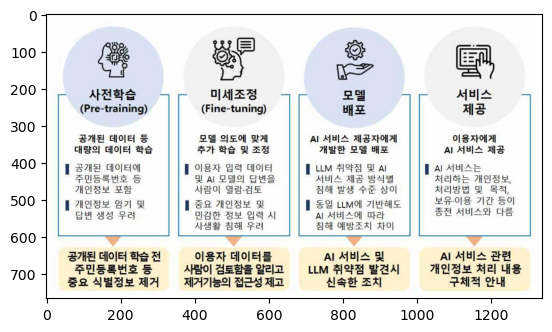

이 이미지는 AI 서비스를 구축하고 제공하는 단계를 설명하고 있습니다. 첫 번째 단계는 사전학습(Pre-training)으로, 공개된 대량의 데이터를 활용하여 모델을 학습시킵니다.
두 번째 단계는 미세조정(Fine-tuning)으로, 특정 업무에 맞게 모델의 지식과 성능을 개선합니다. 세 번째 단계는 모델 배포로, 개발한 AI 모델을 서비스에 배포하여
고객에게 제공할 수 있습니다. 마지막 단계는 서비스 제공으로, AI 서비스를 지속적으로 모니터링하고 개선하여 최적의 서비스를 제공합니다.
metadata:
 {'img_path': './fig/figure-1-1.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '4fc1b9b3-ae35-40ba-b88a-b344d4c5ecfc', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Category: Image, Chunk: 200 Characters
-----------------------------------------------


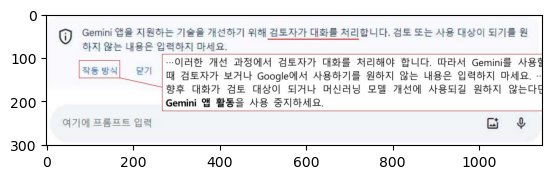

이미지는 Gemini 앱의 서비스에 대해 설명하고 있습니다. 주요 내용으로는 Gemini 앱을 사용하면 개선 과정에서 검토자가 대화를 처리해야 하며, Google에서 사용하기를
원하지 않는 내용은 암호화되어 있다는 점, 그리고 Gemini 앱 활용을 통해 작업을 중지할 수 있다는 내용을 담고 있습니다. 모바일 개선에 사용되길 권장하는 서비스인 것
같습니다.
metadata:
 {'img_path': './fig/figure-6-19.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '99f1b665-a9a3-4434-928b-1522ad5aa086', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
3. Category: Image, Chunk: 151 Characters
-----------------------------------------------


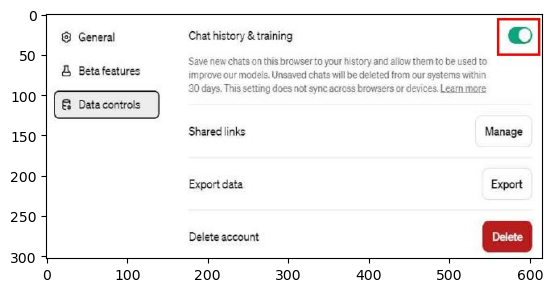

주어진 이미지는 AI 채팅 모델의 설정 메뉴를 보여주고 있습니다. 일반, 베타 기능, 데이터 제어 등의 옵션이 있으며, 채팅 내역과 모델 학습 데이터를 저장하거나 공유 링크를
관리할 수 있습니다. 또한 사용자 데이터를 내보내거나 계정을 삭제할 수 있는 옵션도 제공됩니다.
metadata:
 {'img_path': './fig/figure-7-25.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '3b505967-2604-479b-831b-c1afe87d1955', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
4. Category: Image, Chunk: 184 Characters
-----------------------------------------------


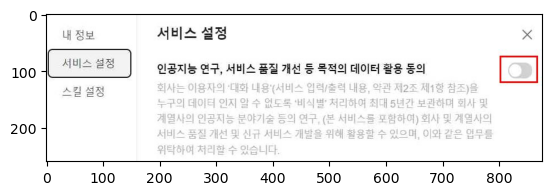

주어진 이미지는 서비스 설정 화면을 보여줍니다. "서비스 설정" 메뉴에서 "인공지능 옵션, 서비스 품질 개선 등 목적의 데이터 활용 동의" 여부를 선택할 수 있는 토글 스위치가
있습니다. 이 옵션은 사용자들이 서비스 품질 개선과 인공지능 모델 학습을 위해 데이터를 수집하고 활용하는 것에 동의하는지 여부를 선택할 수 있게 합니다.
metadata:
 {'img_path': './fig/figure-7-20.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '0766a704-ff80-455a-9078-e73b7f37ec54', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
5. Category: Image, Chunk: 141 Characters
-----------------------------------------------


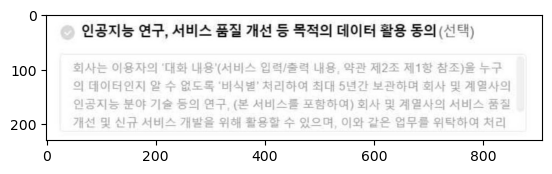

이 이미지는 인공지능 연구, 서비스 품질 개선 등 목적의 데이터 활용 동의에 대해 설명하고 있습니다. 개인정보 보호와 신뢰 서비스 제공을 위해 데이터 활용에 동의할 수 있음을
안내하며, 이런 절차를 거쳐 데이터가 수집되고 활용될 것임을 알리고 있습니다.
metadata:
 {'img_path': './fig/table-1.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '5e86af97-f945-4921-8cf8-5653ba302fe6', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
6. Category: Image, Chunk: 169 Characters
-----------------------------------------------


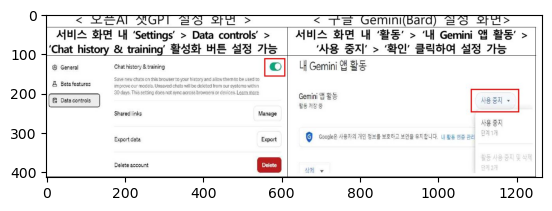

이미지는 Google AI 채팅봇 Gemini(Bard)의 설정 화면을 보여주고 있습니다. 왼쪽에는 일반 설정, 베타 기능, 데이터 관리 등의 옵션이 있고, 오른쪽에는 Gemini
앱 활동 관리, 계정 삭제 등의 옵션이 제공되고 있습니다. 개인정보 보호를 위해 특정 개인이나 단체를 언급하지 않겠습니다.
metadata:
 {'img_path': './fig/figure-5-16.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'b5c85094-80fb-400b-9e5e-a3860d80b010', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
7. Category: Image, Chunk: 149 Characters
-----------------------------------------------


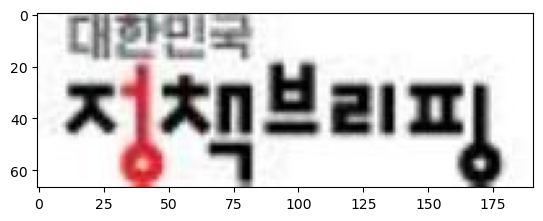

제시된 이미지는 대체 리프트(자체브리핑)라는 한국어 문구가 적혀있는 것으로 보입니다. 흰색 바탕에 검정색 한글 글자로 되어 있으며, 심플하고 간결한 디자인입니다. 구체적인 내용이나
의미는 알 수 없지만, '대체 리프트' 또는 '자체브리핑'과 관련된 것으로 추측됩니다.
metadata:
 {'img_path': './fig/figure-1-10.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'c2c1ea5b-18cf-4fe8-b6d4-8544ba7847fd', 'origin_image': '',
'orig_elements': ''}


In [106]:
show_context_used(search_hybrid_result)